In [1]:
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
import os
from tqdm import tqdm
import enzope
from enzope.graphs.graph_class import GTG

In [2]:
datapath = os.path.join(os.getcwd(), 'data')
figpath = os.path.join(os.getcwd(), 'figs')

def r1(x):
    return x**(-1)

# f(w) = (a/m) * (w/m)^-(a+1)
a, m = 1.5, 1  # shape and mode

In [3]:
def print_info(gtgs):
    cons = [gtgs[i].get_mean_connectivity() for i in range(len(gtgs))] 
    clust = [[nx.average_clustering(gtgs[i].G) for i in range(len(gtgs))]]
    assort = [nx.degree_assortativity_coefficient(gtgs[i].G) for i in range(len(gtgs))]
    print(f"Mean k: {np.mean(cons):.2f} +- {np.std(cons):.2f}")
    print(f"Mean clustering: {np.mean(clust):.2f} +- {np.std(clust):.2f}")
    print(f"Mean assortativity: {np.mean(assort):.2f} +- {np.std(assort):.2f}")

In [42]:
def simulate(
    n_nodes=1000,
    runs=10,
    mcs=20000,
    f = 0,
    gtgs=None,
    filename="testing",
):
    # Funcion para simular un yard-sale en redes gtg
    models = [
        enzope.models.model.CPUModel(
            n_agents=n_nodes,
            f = f,
            G=gtgs[i] if gtgs is not None else None,
            measure_every=1,
        )
        for i in range(runs)
    ]
    ginis = np.zeros((runs, mcs))
    n_actives = np.zeros((runs, mcs))
    n_frozen = []
    liquiditys = np.zeros((runs, mcs - 1))
    
    for i in tqdm(range(runs)):
        models[i].MCS(mcs)
        ginis[i] = models[i].gini
        n_actives[i] = models[i].n_active
        n_frozen.append(models[i].n_frozen)
        liquiditys[i] = models[i].liquidity
    np.save(os.path.join(datapath, filename, f"gini_f={f}_third_run.npy"), ginis)
    np.save(os.path.join(datapath, filename, f"n_actives_f={f}_third_run.npy"), n_actives)
    np.save(os.path.join(datapath, filename, f"n_frozen_f={f}_third_run.npy"), n_frozen)
    np.save(os.path.join(datapath, filename, f"liquidity_f={f}_third_run.npy"), liquiditys)

### Simulacion de todas las redes

### Simulacion para varios $f$

In [43]:
# Valores de theta para tener aprox 6 +- 1 neighs (con 1000 nodos)
# AddExpR2 = 900, MulExpR2 = 450, AddParR2 = 2800, MulParR2 = 3800,
# AddExpR1 = 55, MulExpR1 = 40, AddParrR1 = 200, MulParR1 = 380,
n_nodes = 1000
mcs = 30000
reps = 10
f_set = [0, .1, .15, .2]

for f in f_set:
    print("-----------------------")
    print(f"0: Mean Field, f={f}")
    print("-----------------------")
    simulate(n_nodes=n_nodes, f=f, runs=reps, mcs=mcs, filename="mean_field")

    print("-----------------------")
    print("1: AddExpR2")
    print("-----------------------")
    theta = 900
    gtgs = [enzope.graphs.graph_class.GTG(n_nodes=n_nodes, theta=theta, join='add') for i in range(reps)]
    print_info(gtgs)
    simulate(n_nodes=n_nodes, f=f, runs=reps, mcs=mcs, gtgs=gtgs, filename="add_exp_r2")

    print("-----------------------")
    print("2: MulExpR2")
    print("-----------------------")
    theta = 450
    gtgs = [enzope.graphs.graph_class.GTG(n_nodes=n_nodes, theta=theta, join='mul') for i in range(reps)]
    print_info(gtgs)
    simulate(n_nodes=n_nodes, f=f, runs=reps, mcs=mcs, gtgs=gtgs, filename="mul_exp_r2")

    print("-----------------------")
    print("3: AddParR2")
    print("-----------------------")
    theta = 2800
    weights = [dict(enumerate((np.random.default_rng().pareto(a, n_nodes) + 1) * m)) for _ in range(reps)]
    gtgs = [enzope.graphs.graph_class.GTG(n_nodes=n_nodes, theta=theta, w0=weights[i], join='add') for i in range(reps)]
    print_info(gtgs)
    simulate(n_nodes=n_nodes, f=f, runs=reps, mcs=mcs, gtgs=gtgs, filename="add_par_r2")

    print("-----------------------")
    print("4: MulParR2")
    print("-----------------------")
    theta = 3800
    weights = [dict(enumerate((np.random.default_rng().pareto(a, n_nodes) + 1) * m)) for _ in range(reps)]
    gtgs = [enzope.graphs.graph_class.GTG(n_nodes=n_nodes, theta=theta, w0=weights[i], join='mul') for i in range(reps)]
    print_info(gtgs)
    simulate(n_nodes=n_nodes, f=f, runs=reps, mcs=mcs, gtgs=gtgs, filename="mul_par_r2")

    print("-----------------------")
    print("5: AddExpR1")
    print("-----------------------")
    theta = 55
    gtgs = [enzope.graphs.graph_class.GTG(n_nodes=n_nodes, theta=theta, join='add', p_dist=r1) for i in range(reps)]
    print_info(gtgs)
    simulate(n_nodes=n_nodes, f=f, runs=reps, mcs=mcs, gtgs=gtgs, filename="add_exp_r1")

    print("-----------------------")
    print("6: MulExpR1")
    print("-----------------------")
    theta = 40
    gtgs = [enzope.graphs.graph_class.GTG(n_nodes=n_nodes, theta=theta, join='mul', p_dist=r1) for i in range(reps)]
    print_info(gtgs)
    simulate(n_nodes=n_nodes, f=f, runs=reps, mcs=mcs, gtgs=gtgs, filename="mul_exp_r1")

    print("-----------------------")
    print("7: AddParR1")
    print("-----------------------")
    theta = 200
    weights = [dict(enumerate((np.random.default_rng().pareto(a, n_nodes) + 1) * m)) for _ in range(reps)]
    gtgs = [enzope.graphs.graph_class.GTG(n_nodes=n_nodes, theta=theta, w0=weights[i], join='add', p_dist=r1) for i in range(reps)]
    print_info(gtgs)
    simulate(n_nodes=n_nodes, f=f, runs=reps, mcs=mcs, gtgs=gtgs, filename="add_par_r1")

    print("-----------------------")
    print("8: MulParR1")
    theta = 380
    weights = [dict(enumerate((np.random.default_rng().pareto(a, n_nodes) + 1) * m)) for _ in range(reps)]
    gtgs = [enzope.graphs.graph_class.GTG(n_nodes=n_nodes, theta=theta, w0=weights[i], join='mul', p_dist=r1) for i in range(reps)]
    print_info(gtgs)
    simulate(n_nodes=n_nodes, f=f, runs=reps, mcs=mcs, gtgs=gtgs, filename="mul_par_r1")

-----------------------
0: Mean Field, f=0
-----------------------


100%|██████████| 10/10 [09:42<00:00, 58.22s/it]


-----------------------
1: AddExpR2
-----------------------
Mean k: 6.75 +- 0.23
Mean clustering: 0.62 +- 0.01
Mean assortativity: 0.07 +- 0.07


100%|██████████| 10/10 [1:06:54<00:00, 401.49s/it]


-----------------------
2: MulExpR2
-----------------------
Mean k: 6.66 +- 0.32
Mean clustering: 0.52 +- 0.01
Mean assortativity: 0.06 +- 0.05


100%|██████████| 10/10 [1:01:18<00:00, 367.90s/it]


-----------------------
3: AddParR2
-----------------------
Mean k: 6.29 +- 0.33
Mean clustering: 0.65 +- 0.03
Mean assortativity: -0.07 +- 0.05


100%|██████████| 10/10 [1:06:51<00:00, 401.18s/it]


-----------------------
4: MulParR2
-----------------------
Mean k: 6.00 +- 0.88
Mean clustering: 0.62 +- 0.05
Mean assortativity: -0.08 +- 0.04


100%|██████████| 10/10 [1:05:37<00:00, 393.76s/it]


-----------------------
5: AddExpR1
-----------------------
Mean k: 5.78 +- 0.28
Mean clustering: 0.63 +- 0.01
Mean assortativity: -0.12 +- 0.02


100%|██████████| 10/10 [1:06:26<00:00, 398.69s/it]


-----------------------
6: MulExpR1
-----------------------
Mean k: 6.36 +- 0.75
Mean clustering: 0.39 +- 0.03
Mean assortativity: -0.07 +- 0.02


100%|██████████| 10/10 [51:55<00:00, 311.52s/it]


-----------------------
7: AddParR1
-----------------------
Mean k: 5.53 +- 2.23
Mean clustering: 0.70 +- 0.18
Mean assortativity: -0.26 +- 0.07


100%|██████████| 10/10 [1:05:49<00:00, 394.95s/it]


-----------------------
8: MulParR1
Mean k: 7.00 +- 1.88
Mean clustering: 0.60 +- 0.15
Mean assortativity: -0.36 +- 0.07


100%|██████████| 10/10 [1:04:50<00:00, 389.05s/it]


-----------------------
0: Mean Field, f=0.1
-----------------------


100%|██████████| 10/10 [24:29<00:00, 146.96s/it]


-----------------------
1: AddExpR2
-----------------------
Mean k: 6.72 +- 0.23
Mean clustering: 0.63 +- 0.01
Mean assortativity: 0.06 +- 0.04


100%|██████████| 10/10 [1:24:02<00:00, 504.28s/it]


-----------------------
2: MulExpR2
-----------------------
Mean k: 6.35 +- 0.35
Mean clustering: 0.52 +- 0.01
Mean assortativity: 0.06 +- 0.02


100%|██████████| 10/10 [1:19:22<00:00, 476.28s/it]


-----------------------
3: AddParR2
-----------------------
Mean k: 6.27 +- 0.57
Mean clustering: 0.66 +- 0.04
Mean assortativity: -0.08 +- 0.03


100%|██████████| 10/10 [1:25:32<00:00, 513.23s/it]


-----------------------
4: MulParR2
-----------------------
Mean k: 5.99 +- 0.45
Mean clustering: 0.63 +- 0.02
Mean assortativity: -0.08 +- 0.03


100%|██████████| 10/10 [1:22:20<00:00, 494.02s/it]


-----------------------
5: AddExpR1
-----------------------
Mean k: 5.94 +- 0.33
Mean clustering: 0.64 +- 0.01
Mean assortativity: -0.14 +- 0.03


100%|██████████| 10/10 [1:23:32<00:00, 501.20s/it]


-----------------------
6: MulExpR1
-----------------------
Mean k: 6.42 +- 0.62
Mean clustering: 0.39 +- 0.02
Mean assortativity: -0.07 +- 0.03


100%|██████████| 10/10 [1:06:12<00:00, 397.27s/it]


-----------------------
7: AddParR1
-----------------------
Mean k: 6.22 +- 1.20
Mean clustering: 0.80 +- 0.08
Mean assortativity: -0.27 +- 0.03


100%|██████████| 10/10 [1:23:44<00:00, 502.45s/it]


-----------------------
8: MulParR1
Mean k: 6.79 +- 1.84
Mean clustering: 0.59 +- 0.21
Mean assortativity: -0.33 +- 0.07


100%|██████████| 10/10 [1:26:14<00:00, 517.46s/it]


-----------------------
0: Mean Field, f=0.15
-----------------------


  0%|          | 0/10 [00:08<?, ?it/s]


KeyboardInterrupt: 

### Idea para plotear

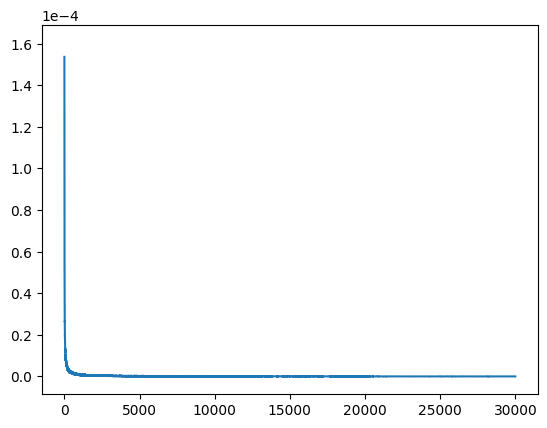

In [60]:
frozen = np.load(os.path.join(datapath, 'add_exp_r1', "liquidity_f=0_third_run.npy"))
frozen_mean = np.mean(frozen, axis=0)
frozen_std = np.std(frozen, axis=0)
plt.plot(frozen_mean, label="f=0")
plt.fill_between(
        np.arange(frozen_mean.shape[0]),
        frozen_mean - frozen_std,
        frozen_mean + frozen_std,
        alpha=0.3,
    )
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

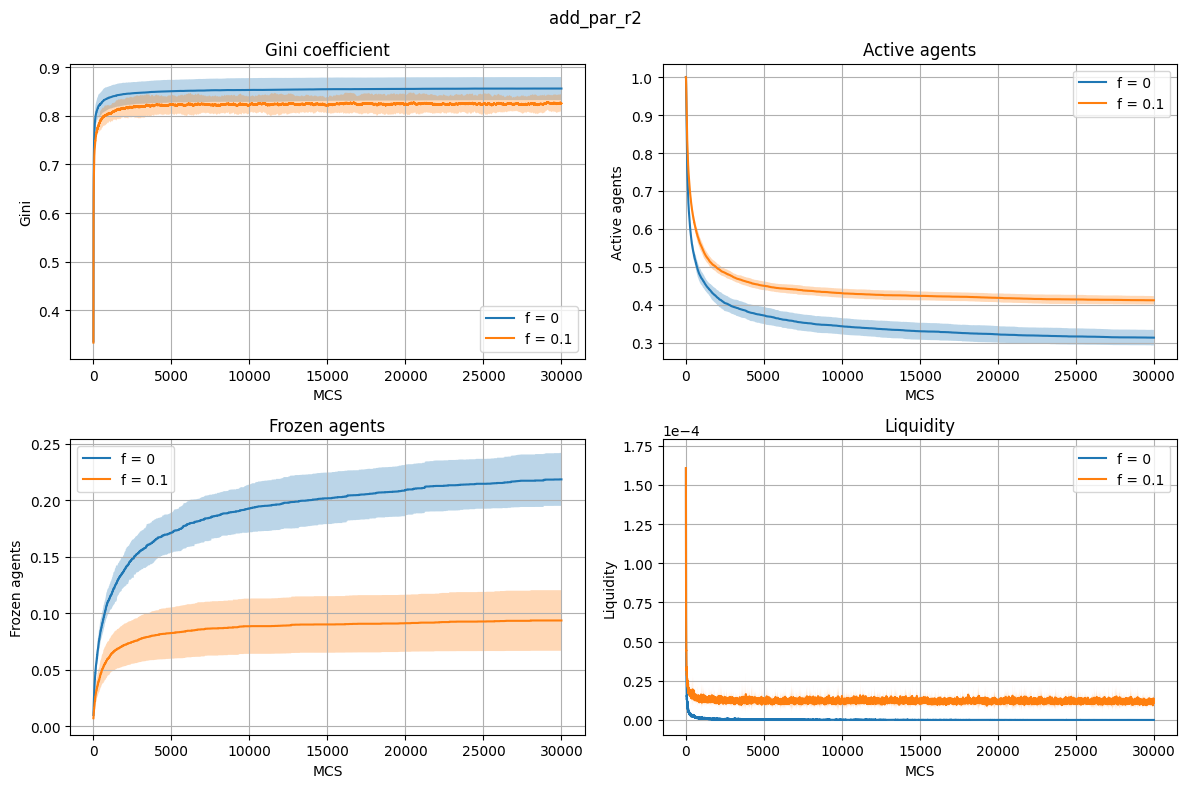

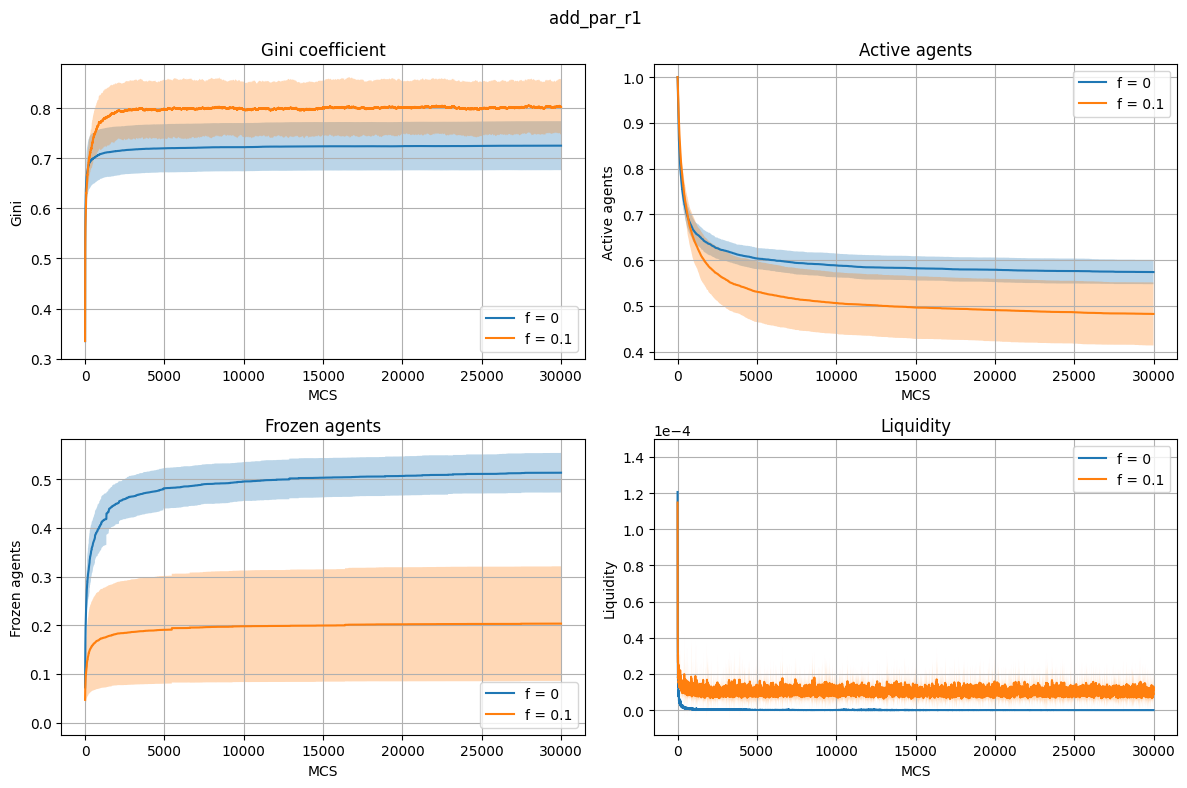

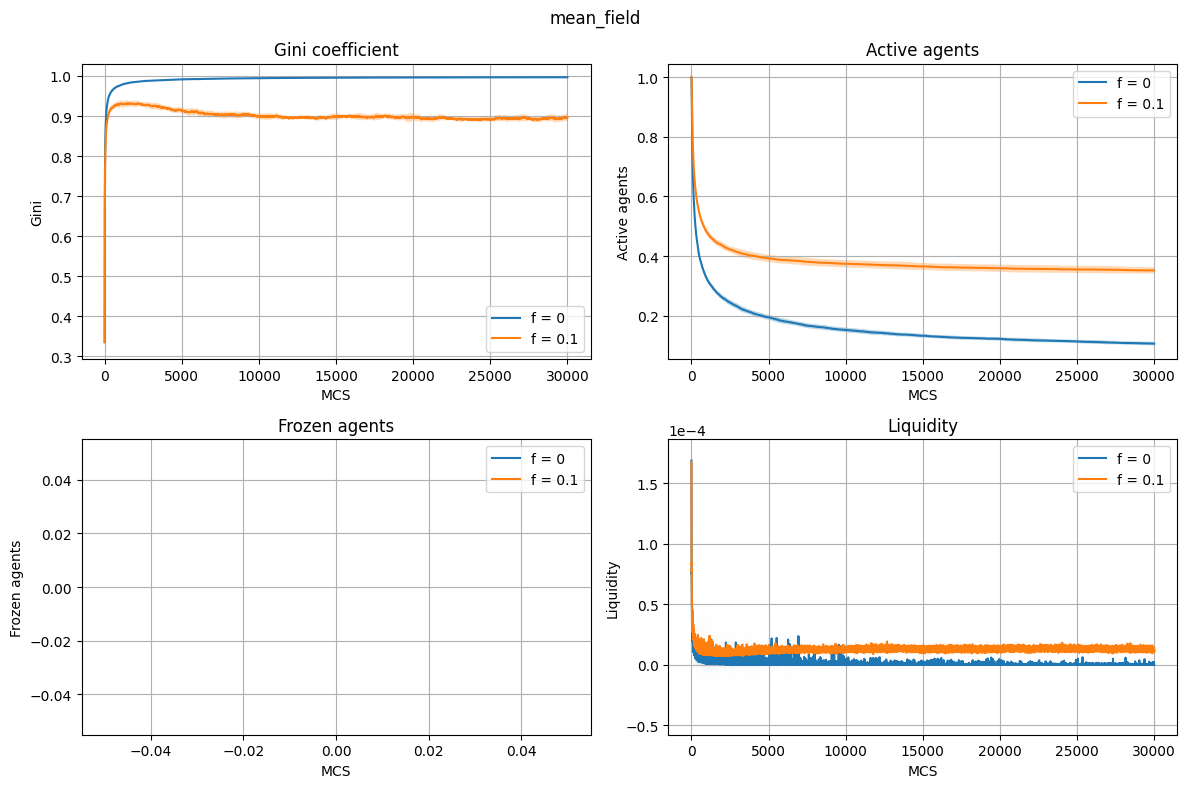

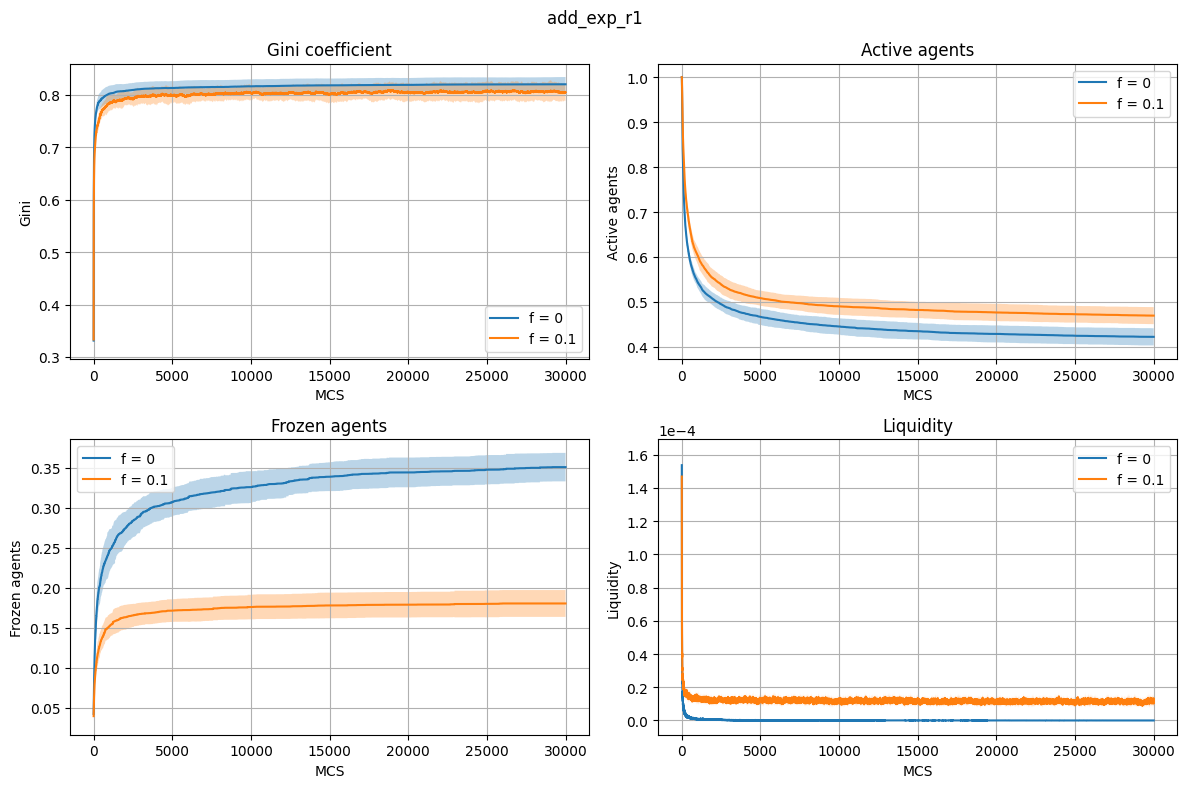

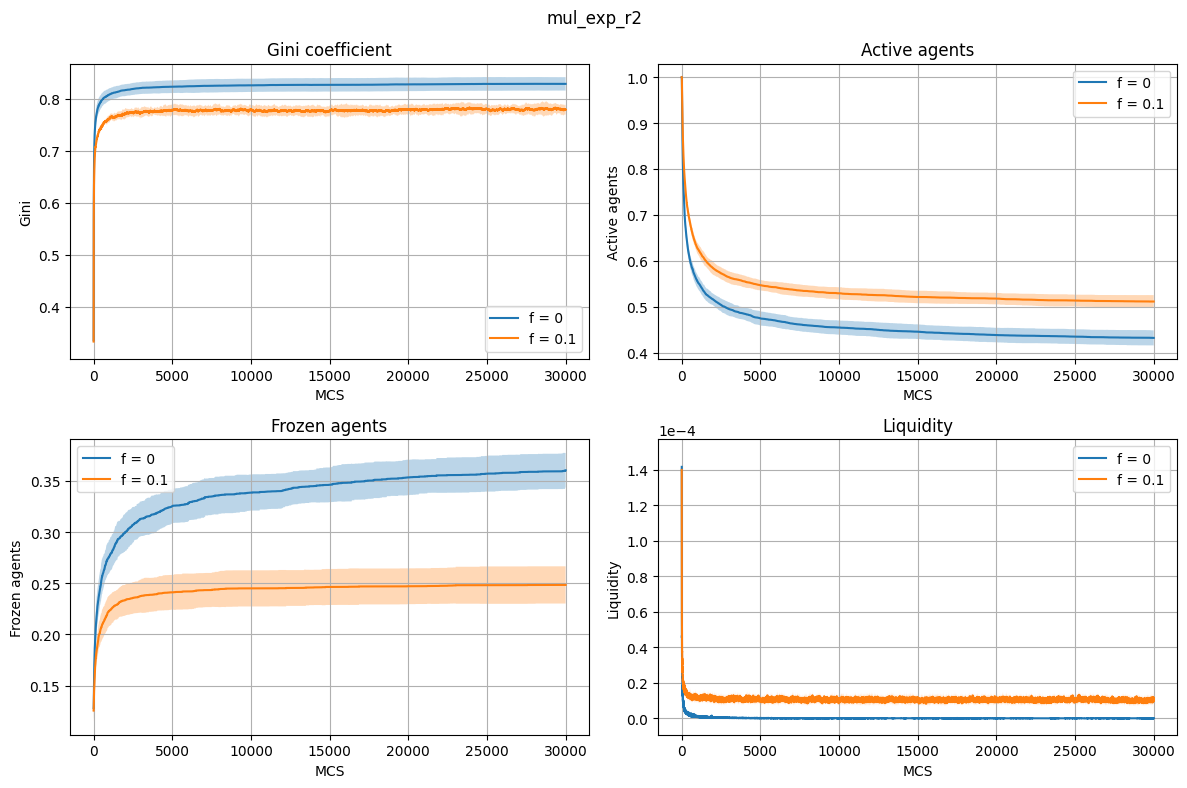

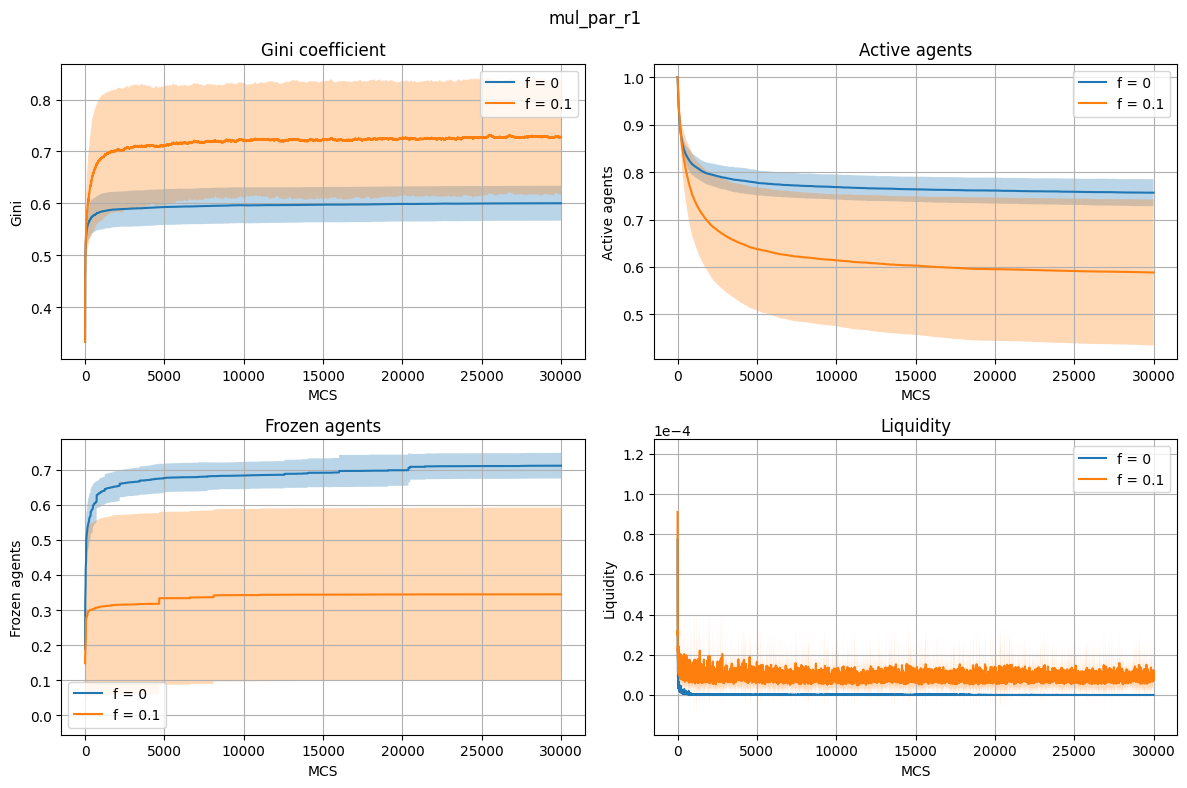

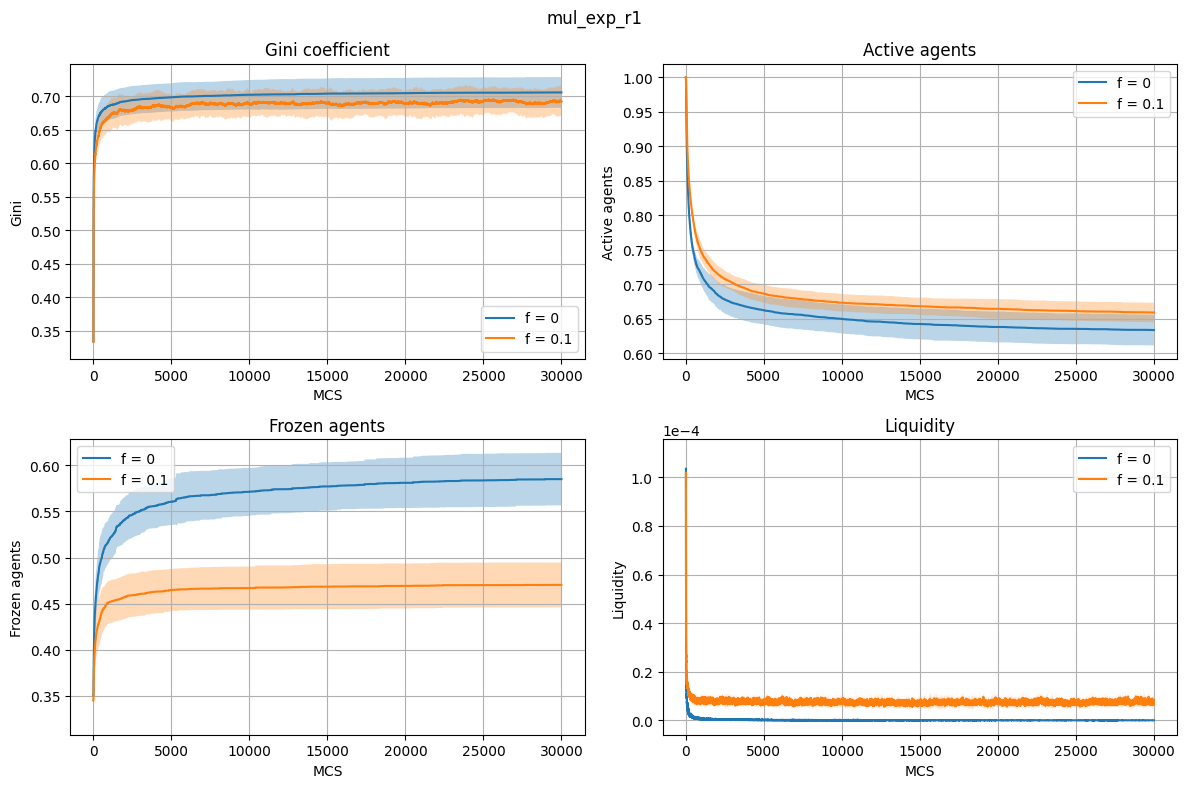

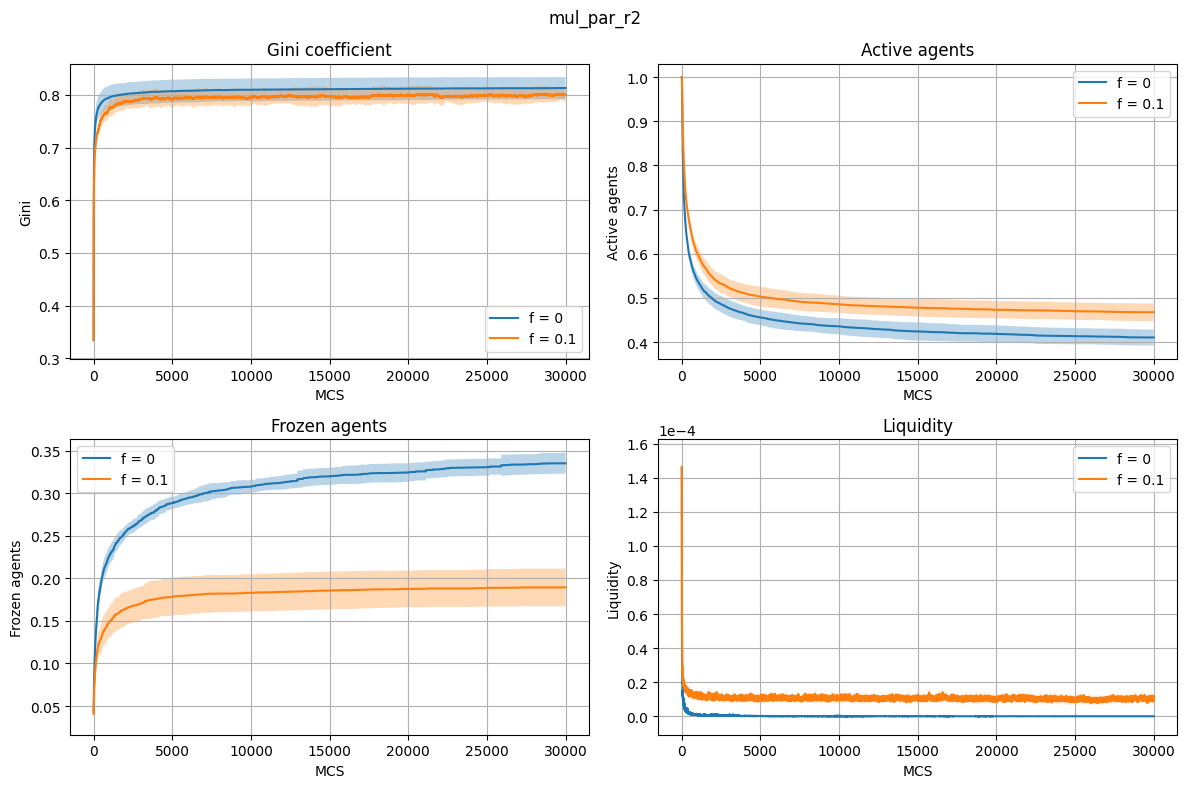

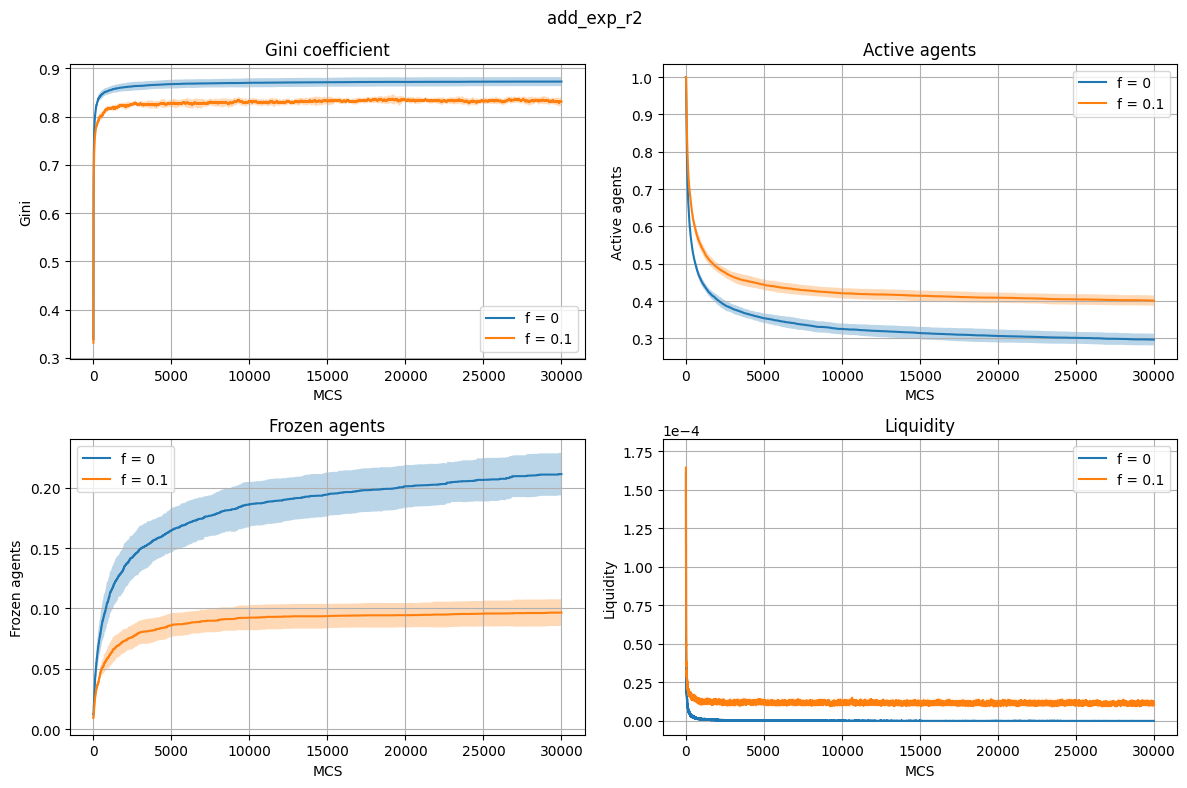

In [61]:
# Load files and calculate means and stds
# filename = 'mul_par_r2'
for filename in os.listdir(datapath):
    ginis = np.load(os.path.join(datapath, filename, "gini_f=0_third_run.npy"))
    n_actives = np.load(os.path.join(datapath, filename, "n_actives_f=0_third_run.npy"))
    liquiditys = np.load(os.path.join(datapath, filename, "liquidity_f=0_third_run.npy"))
    frozen = np.load(os.path.join(datapath, filename, "n_frozen_f=0_third_run.npy"))
    ginis_f = np.load(os.path.join(datapath, filename, "gini_f=0.1_third_run.npy"))
    n_actives_f = np.load(os.path.join(datapath, filename, "n_actives_f=0.1_third_run.npy"))
    liquiditys_f = np.load(os.path.join(datapath, filename, "liquidity_f=0.1_third_run.npy"))
    frozen_f = np.load(os.path.join(datapath, filename, "n_frozen_f=0.1_third_run.npy"))

    ginis_mean = np.mean(ginis, axis=0)
    ginis_std = np.std(ginis, axis=0)
    n_actives_mean = np.mean(n_actives, axis=0)
    n_actives_std = np.std(n_actives, axis=0)
    liquiditys_mean = np.mean(liquiditys, axis=0)
    liquiditys_std = np.std(liquiditys, axis=0)
    frozen_mean = np.mean(frozen, axis=0)
    frozen_std = np.std(frozen, axis=0)
    ginis_mean_f = np.mean(ginis_f, axis=0)
    ginis_std_f = np.std(ginis_f, axis=0)
    n_actives_mean_f = np.mean(n_actives_f, axis=0)
    n_actives_std_f = np.std(n_actives_f, axis=0)
    liquiditys_mean_f = np.mean(liquiditys_f, axis=0)
    liquiditys_std_f = np.std(liquiditys_f, axis=0)
    frozen_mean_f = np.mean(frozen_f, axis=0)
    frozen_std_f = np.std(frozen_f, axis=0)
    

    # Plotting
    # fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    ax = ax.flatten()

    ax[0].plot(ginis_mean, label='f = 0')
    ax[0].fill_between(
        np.arange(ginis_mean.shape[0]), ginis_mean - ginis_std, ginis_mean + ginis_std, alpha=0.3
    )
    ax[0].plot(ginis_mean_f, label="f = 0.1")
    ax[0].fill_between(
        np.arange(ginis_mean_f.shape[0]), ginis_mean_f - ginis_std_f, ginis_mean_f + ginis_std_f, alpha=0.3
    )

    ax[0].legend()
    ax[0].grid()
    ax[0].set_xlabel("MCS")
    ax[0].set_ylabel("Gini")
    ax[0].set_title("Gini coefficient")

    ax[1].plot(n_actives_mean, label="f = 0")
    ax[1].fill_between(
        np.arange(n_actives_mean.shape[0]),
        n_actives_mean - n_actives_std,
        n_actives_mean + n_actives_std,
        alpha=0.3,
    )
    ax[1].plot(n_actives_mean_f, label="f = 0.1")
    ax[1].fill_between(
        np.arange(n_actives_mean_f.shape[0]),
        n_actives_mean_f - n_actives_std_f,
        n_actives_mean_f + n_actives_std_f,
        alpha=0.3,
    )

    ax[1].legend()
    ax[1].grid()
    ax[1].set_xlabel("MCS")
    ax[1].set_ylabel("Active agents")
    ax[1].set_title("Active agents")

    ax[2].plot(frozen_mean, label="f = 0")
    ax[2].fill_between(
        np.arange(frozen_mean.shape[0]),
        frozen_mean - frozen_std,
        frozen_mean + frozen_std,
        alpha=0.3,
    )
    ax[2].plot(frozen_mean_f, label="f = 0.1")
    ax[2].fill_between(
        np.arange(frozen_mean_f.shape[0]),
        frozen_mean_f - frozen_std_f,
        frozen_mean_f + frozen_std_f,
        alpha=0.3,
    )

    ax[2].legend()
    ax[2].grid()
    ax[2].set_xlabel("MCS")
    ax[2].set_ylabel("Frozen agents")
    ax[2].set_title("Frozen agents")


    ax[3].plot(liquiditys_mean, label="f = 0")
    ax[3].fill_between(
        np.arange(liquiditys_mean.shape[0]),
        liquiditys_mean - liquiditys_std,
        liquiditys_mean + liquiditys_std,
        alpha=0.3,
    )
    ax[3].plot(liquiditys_mean_f, label="f = 0.1")
    ax[3].fill_between(
        np.arange(liquiditys_mean_f.shape[0]),
        liquiditys_mean_f - liquiditys_std_f,
        liquiditys_mean_f + liquiditys_std_f,
        alpha=0.3,
    )

    ax[3].legend()
    ax[3].grid()
    ax[3].set_xlabel("MCS")
    ax[3].set_ylabel("Liquidity")
    ax[3].set_title("Liquidity")
    ax[3].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    fig.suptitle(filename)
    plt.tight_layout()
    fig.savefig(os.path.join(figpath, str(filename) + "_third_run.png"), dpi=600)
    plt.show()


In [81]:
n = 500
weights = [dict(enumerate((np.random.default_rng().pareto(a, n_nodes) + 1) * m)) for i in range(n)]
redes = [enzope.graphs.graph_class.GTG(n_nodes=1000, theta = 380, w0=weights[i], p_dist=r1, plotable=True, join='mul') for i in range(n)]
print_info(redes)
# redes[0].plot_snapshot()


Mean k: 6.45 +- 1.88
Mean clustering: 0.56 +- 0.18
Mean assortativity: -0.36 +- 0.06


### Voy a correr de nuevo para los casos de Pareto y r1 a ver que onda

In [87]:
n_nodes = 1000
mcs = 10000
reps = 30
f_set = [0, .1, .15, .2]

for f in f_set:
    print("-----------------------")
    print("7: AddParR1")
    print("-----------------------")
    theta = 200
    weights = [dict(enumerate((np.random.default_rng().pareto(a, n_nodes) + 1) * m)) for _ in range(reps)]
    gtgs = [enzope.graphs.graph_class.GTG(n_nodes=n_nodes, theta=theta, w0=weights[i], join='add', p_dist=r1) for i in range(reps)]
    print_info(gtgs)
    simulate(n_nodes=n_nodes, f=f, runs=reps, mcs=mcs, gtgs=gtgs, filename="add_par_r1")

    print("-----------------------")
    print("8: MulParR1")
    theta = 380
    weights = [dict(enumerate((np.random.default_rng().pareto(a, n_nodes) + 1) * m)) for _ in range(reps)]
    gtgs = [enzope.graphs.graph_class.GTG(n_nodes=n_nodes, theta=theta, w0=weights[i], join='mul', p_dist=r1) for i in range(reps)]
    print_info(gtgs)
    simulate(n_nodes=n_nodes, f=f, runs=reps, mcs=mcs, gtgs=gtgs, filename="mul_par_r1")
    

-----------------------
7: AddParR1
-----------------------
Mean k: 6.55 +- 2.33
Mean clustering: 0.78 +- 0.13
Mean assortativity: -0.31 +- 0.09


100%|██████████| 30/30 [1:10:39<00:00, 141.31s/it]


-----------------------
8: MulParR1
Mean k: 6.38 +- 1.46
Mean clustering: 0.55 +- 0.13
Mean assortativity: -0.37 +- 0.06


100%|██████████| 30/30 [1:02:39<00:00, 125.30s/it]


-----------------------
7: AddParR1
-----------------------
Mean k: 6.42 +- 2.10
Mean clustering: 0.78 +- 0.14
Mean assortativity: -0.29 +- 0.08


100%|██████████| 30/30 [1:27:01<00:00, 174.05s/it]


-----------------------
8: MulParR1
Mean k: 6.53 +- 2.19
Mean clustering: 0.56 +- 0.20
Mean assortativity: -0.37 +- 0.05


100%|██████████| 30/30 [1:20:36<00:00, 161.22s/it]


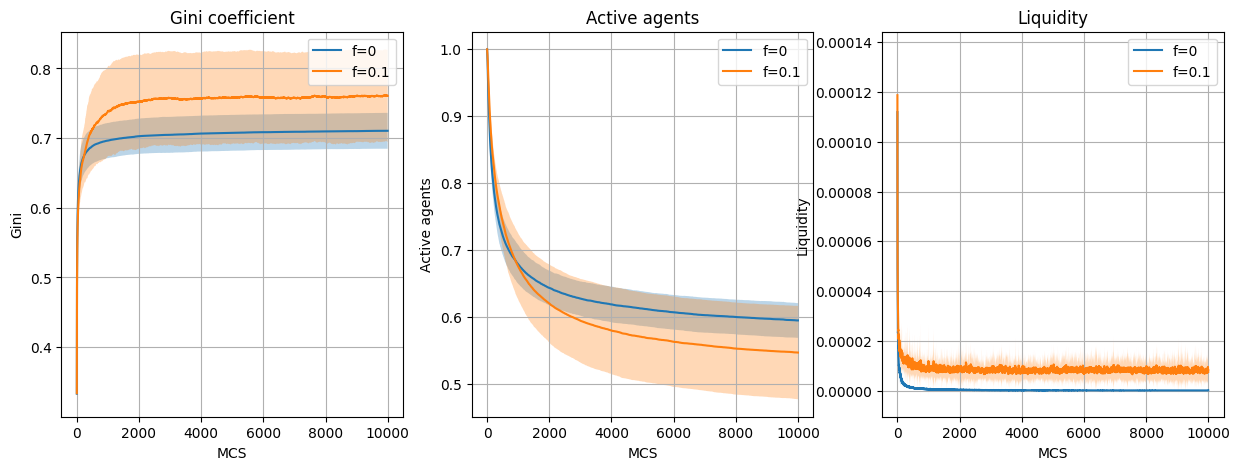

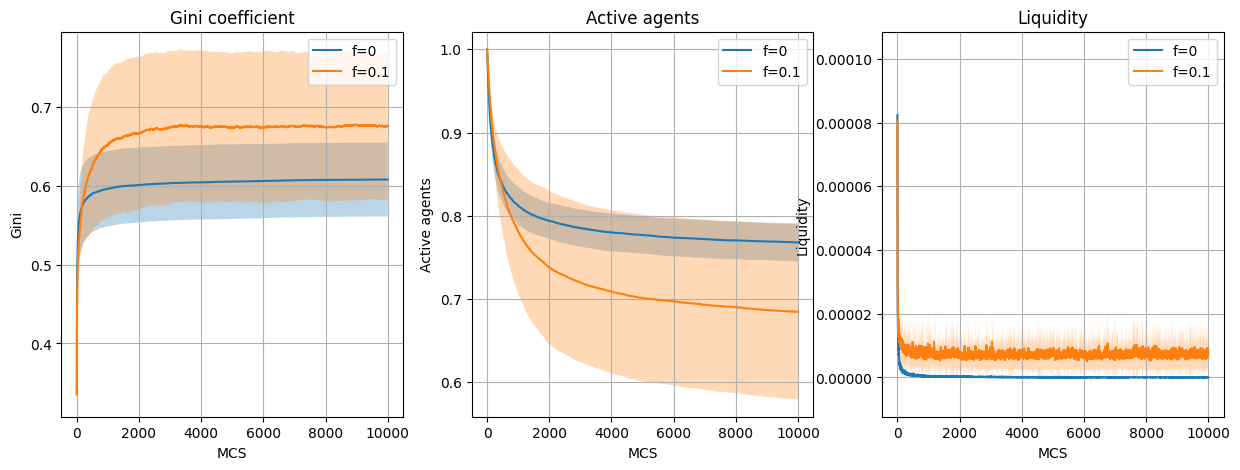

In [92]:
for filename in ['add_par_r1', 'mul_par_r1']:
    ginis = np.load(os.path.join(datapath, filename, "gini_f=0.npy"))
    n_actives = np.load(os.path.join(datapath, filename, "n_actives_f=0.npy"))
    liquiditys = np.load(os.path.join(datapath, filename, "liquidity_f=0.npy"))
    ginis_f = np.load(os.path.join(datapath, filename, "gini_f=0.15.npy"))
    n_actives_f = np.load(os.path.join(datapath, filename, "n_actives_f=0.15.npy"))
    liquiditys_f = np.load(os.path.join(datapath, filename, "liquidity_f=0.15.npy"))

    ginis_mean = np.mean(ginis, axis=0)
    ginis_std = np.std(ginis, axis=0)
    n_actives_mean = np.mean(n_actives, axis=0)
    n_actives_std = np.std(n_actives, axis=0)
    liquiditys_mean = np.mean(liquiditys, axis=0)
    liquiditys_std = np.std(liquiditys, axis=0)
    ginis_mean_f = np.mean(ginis_f, axis=0)
    ginis_std_f = np.std(ginis_f, axis=0)
    n_actives_mean_f = np.mean(n_actives_f, axis=0)
    n_actives_std_f = np.std(n_actives_f, axis=0)
    liquiditys_mean_f = np.mean(liquiditys_f, axis=0)
    liquiditys_std_f = np.std(liquiditys_f, axis=0)


    # Plotting
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    for f in f_set[0:2]:
        ginis = np.load(os.path.join(datapath, filename, f"gini_f={f}.npy"))
        n_actives = np.load(os.path.join(datapath, filename, f"n_actives_f={f}.npy"))
        liquiditys = np.load(os.path.join(datapath, filename, f"liquidity_f={f}.npy"))
        ginis_mean = np.mean(ginis, axis=0)
        ginis_std = np.std(ginis, axis=0)
        n_actives_mean = np.mean(n_actives, axis=0)
        n_actives_std = np.std(n_actives, axis=0)
        liquiditys_mean = np.mean(liquiditys, axis=0)
        liquiditys_std = np.std(liquiditys, axis=0)
 
        ax[0].plot(ginis_mean, label=f'f={f}')
        ax[0].fill_between(
            np.arange(ginis_mean.shape[0]), ginis_mean - ginis_std, ginis_mean + ginis_std, alpha=0.3
        )


        ax[1].plot(n_actives_mean, label=f"f={f}")
        ax[1].fill_between(
            np.arange(n_actives_mean.shape[0]),
            n_actives_mean - n_actives_std,
            n_actives_mean + n_actives_std,
            alpha=0.3,
        )


        ax[2].plot(liquiditys_mean, label=f"f={f}")
        ax[2].fill_between(
            np.arange(liquiditys_mean.shape[0]),
            liquiditys_mean - liquiditys_std,
            liquiditys_mean + liquiditys_std,
            alpha=0.3,
        )


    ax[0].legend()
    ax[0].grid()
    ax[0].set_xlabel("MCS")
    ax[0].set_ylabel("Gini")
    ax[0].set_title("Gini coefficient")
    
    ax[1].legend()
    ax[1].grid()
    ax[1].set_xlabel("MCS")
    ax[1].set_ylabel("Active agents")
    ax[1].set_title("Active agents")

    ax[2].legend()
    ax[2].grid()
    ax[2].set_xlabel("MCS")
    ax[2].set_ylabel("Liquidity")
    ax[2].set_title("Liquidity")
    # fig.savefig(os.path.join(figpath, str(filename) + "_third_run.png"), dpi=300)
    # plt.show()


In [163]:
n_nodes = 1000
m = 1/3

for reps in [5, 10, 15, 20, 30, 40, 50]:
    weights = [dict(enumerate((np.random.default_rng().pareto(a, n_nodes) + 1) * m)) for _ in range(reps)]
    gtgs = [enzope.graphs.graph_class.GTG(n_nodes=n_nodes, theta=theta/9, w0=weights[i], join='mul', p_dist=r1) for i in range(reps)]
    print_info(gtgs)
    print("-------")

Mean k: 6.45 +- 0.96
Mean clustering: 0.54 +- 0.07
Mean assortativity: -0.41 +- 0.05
-------
Mean k: 5.50 +- 1.16
Mean clustering: 0.47 +- 0.11
Mean assortativity: -0.37 +- 0.05
-------
Mean k: 6.58 +- 1.55
Mean clustering: 0.58 +- 0.16
Mean assortativity: -0.36 +- 0.06
-------
Mean k: 6.57 +- 1.44
Mean clustering: 0.58 +- 0.14
Mean assortativity: -0.37 +- 0.05
-------
Mean k: 6.45 +- 2.12
Mean clustering: 0.55 +- 0.15
Mean assortativity: -0.37 +- 0.07
-------
Mean k: 6.64 +- 1.88
Mean clustering: 0.57 +- 0.15
Mean assortativity: -0.37 +- 0.08
-------
Mean k: 6.76 +- 2.11
Mean clustering: 0.60 +- 0.19
Mean assortativity: -0.36 +- 0.06
-------


In [159]:
aa = 1.5
mm = 1/3

s = (np.random.default_rng().pareto(aa, 10000) + 1) * mm

gg = GTG(n_nodes=1000, theta=700)
np.mean([gg.G.nodes[i]['weight'] for i in range(1000)])
np.mean(s)

0.9893305807593199

### Algunas propiedades de red BA y ER

In [218]:
nodes = 6000
ba = nx.barabasi_albert_graph(nodes, 4)
# Average number of nodes, clustering and degree assortativity
np.mean([ba.degree[i] for i in range(nodes)]), nx.average_clustering(ba), nx.degree_assortativity_coefficient(ba)

(7.994666666666666, 0.00892978260385909, -0.03305797774190998)

In [185]:
# Same for erdos renyi graph
er = nx.erdos_renyi_graph(1000, 0.008)
np.mean([er.degree[i] for i in range(1000)]), nx.average_clustering(er), nx.degree_assortativity_coefficient(er)

(7.982, 0.008784314541667483, -0.01968690353402732)